# **Case Study**

The Akahappa Company specializes in ready-to-eat meals. The company operates a three-tier supply chain with a factory, warehouses, and retailers. Akahappa delivers directly to the warehouses of its two largest distributors. The sales department records sales on a daily basis, which are then used by the operations
department for developing forecasts used for planning purposes.

Since many consumers will switch to the competitor’s brands if product is out-of-stock, underforecasting results in lost sales. On the other hand, overforecasting results in excess inventory, which becomes obsolete and has to be destroyed because of the perishable characteristics of the products. Therefore, producing an accurate forecast is very important.

The company has decided to develop new forecasting models for curry, which is one of the most valuable product categories of the company. The company produces two kinds of curry: green thai curry and vegetable korma curry. The warehouse records sales on a daily basis but only days with sales are reported.
You are given 9 years of sales data.

You are given two sets of data: the historical demand data of green thai curry (DA) and korma curry (DB). Carry out steps 1 to 6.

### **Libraries**

In [ ]:
#Import basic Libraries
import io
import pandas as pd
import numpy as np
from numpy import loadtxt
import scipy as sci
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler # found in the scikit-learn package

from keras.layers import Dense
from keras.layers import LSTM
#from keras.optimizers import SGD
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam # - Works

import tensorflow as tf
from tensorflow.keras.models import Sequential
##from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Outliers section
!pip install hampel
from hampel import hampel
from sklearn.cluster import DBSCAN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
# Normalize the data frame
def scale(data):
    scaled_data = data.copy()
    for column in data.columns: 
      scaled_data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())
    return scaled_data
    
# Scale back the data frame
def scale_back(data, data_min, data_range):
    data_ = data.copy()
    data_.head()
    for column in data_.columns: 
        data_[column] = (data_range) * data_[column] + data_min
    return data_

## **STEP 1** 

Develop neural network models for forecasting the demand of each individual product, i.e. use DA for
green thai curry and DB for vegetable korma curry. In either case, use 85% of the data for training and the
rest for testing. Use a single hidden layer. Vary the number of neurons in the hidden layer using 3, 5, 7,
and 9 neurons (for each architecture, record the Akaike Information Criteria). Let the predictions of each
model be FA and FB, respectively.

* 1.1 Make a table that shows the Akaike Information Criteria for each number of neurons for product-level model FA.
* 1.2 Report the best number of neurons in the hidden layer of the product-level model FA.
* 1.3 Repeat 1.1 and 1.2 for FB.

#### **Import and Arrange Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Read the CSV file, store it as a DataFrame and make sure it has no NaN values
# Vegetable Curry
url_vc='https://drive.google.com/file/d/1Yd4OcWul48u2RLakt3CfmFAs7hrSSVCE/view?usp=sharing'
path_vc ='https://drive.google.com/uc?id=' + url_vc.split('/')[-2]
df_vc = pd.read_csv(path_vc)
print(df_vc.head(3))

# Green Curry
url_gc='https://drive.google.com/file/d/1YXz_BBT83XPFmQgCoIAuY4MCCsz3ohhj/view?usp=sharing'
path_gc ='https://drive.google.com/uc?id=' + url_gc.split('/')[-2]
df_gc = pd.read_csv(path_gc)
print(df_gc.head(3))

# Make sure that there are no NaN values present
print("\n")
print(f"Vegetable Curry")
print(df_vc.info())
print("\n")
print(f"Green Curry")
print(df_vc.info())

       Date  Sales
0  1/1/2011    208
1  1/2/2011    240
2  1/3/2011    206
       Date  Sales
0  1/1/2011    366
1  1/2/2011    301
2  1/3/2011    309


Vegetable Curry
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3650 non-null   object
 1   Sales   3650 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.2+ KB
None


Green Curry
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3650 non-null   object
 1   Sales   3650 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.2+ KB
None


##### **Outliers - Hempel Filter**

* https://medium.com/wwblog/clean-up-your-time-series-data-with-a-hampel-filter-58b0bb3ebb04
* https://pypi.org/project/hampel/

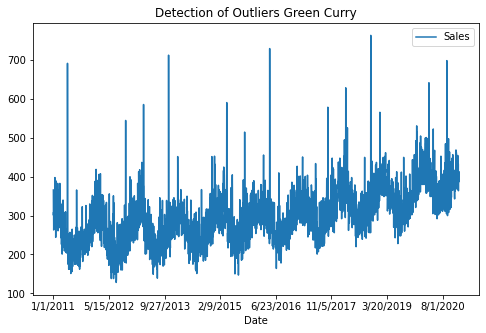

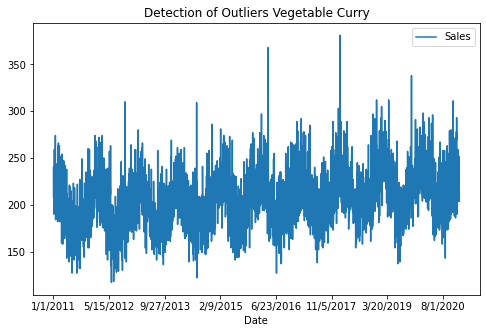

In [ ]:
#Plot the data to find Outliers
df_gc.plot(x='Date',y='Sales',kind='line',figsize=(8,5),title='Detection of Outliers Green Curry')
df_vc.plot(x='Date',y='Sales',kind='line',figsize=(8,5),title='Detection of Outliers Vegetable Curry')

Outlier Indices for Green Curry:  [32, 33, 58, 87, 100, 104, 127, 138, 209, 216, 293, 327, 360, 402, 423, 477, 502, 503, 540, 640, 650, 689, 699, 728, 745, 767, 776, 811, 817, 826, 847, 853, 914, 920, 921, 949, 957, 1004, 1036, 1048, 1099, 1118, 1119, 1125, 1127, 1199, 1202, 1225, 1236, 1311, 1322, 1332, 1344, 1384, 1386, 1391, 1411, 1425, 1449, 1453, 1459, 1473, 1484, 1559, 1575, 1584, 1585, 1598, 1608, 1609, 1610, 1620, 1622, 1626, 1633, 1634, 1654, 1676, 1720, 1811, 1876, 1890, 1905, 1936, 1945, 1950, 1957, 1970, 1973, 1977, 1978, 1987, 2027, 2119, 2145, 2210, 2220, 2260, 2285, 2333, 2358, 2393, 2400, 2409, 2410, 2425, 2436, 2468, 2484, 2507, 2563, 2576, 2577, 2594, 2606, 2629, 2632, 2640, 2644, 2711, 2767, 2772, 2799, 2854, 2866, 2882, 2915, 2922, 2936, 2943, 3020, 3054, 3060, 3078, 3087, 3109, 3111, 3129, 3150, 3158, 3162, 3171, 3229, 3240, 3261, 3267, 3271, 3295, 3302, 3377, 3416, 3471, 3477, 3485, 3486, 3494, 3508, 3515, 3538, 3553, 3561, 3562, 3636]
Outlier Indices for Vegetabl

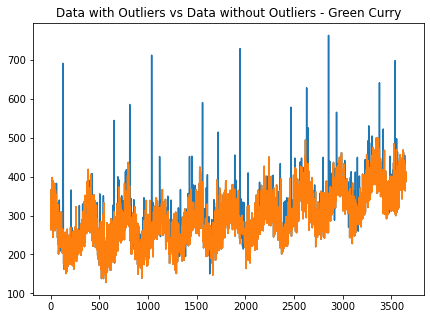

<Figure size 432x288 with 0 Axes>

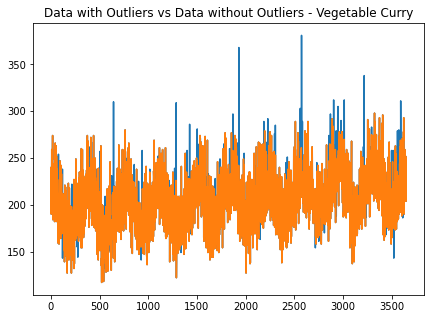

<Figure size 432x288 with 0 Axes>

In [ ]:
# Outlier detection
outlier_indices_gc = hampel(df_gc.Sales, window_size=5, n=3)
print("Outlier Indices for Green Curry: ", outlier_indices_gc)
outlier_indices_vc= hampel(df_vc.Sales, window_size=5, n=3)
print("Outlier Indices for Vegetable Curry: ", outlier_indices_vc)

# Outlier Imputation with rolling median
Outlier_imputation_gc = hampel(df_gc.Sales, window_size=5, n=3, imputation=True) # If set to False, then the algorithm will be used for outlier detection. If set to True, then the algorithm will also imput the outliers with the rolling median.
Outlier_imputation_vc = hampel(df_vc.Sales, window_size=5, n=3, imputation=True) # If set to False, then the algorithm will be used for outlier detection. If set to True, then the algorithm will also imput the outliers with the rolling median.

# Plot Original Data vs. Outliers
## Green Curry
df_gc.Sales.plot(figsize=(7,5),title='Data with Outliers vs Data without Outliers - Green Curry')
Outlier_imputation_gc.plot()
plt.figure()
plt.show()
## Vegetable Curry
df_vc.Sales.plot(figsize=(7,5),title='Data with Outliers vs Data without Outliers - Vegetable Curry')
Outlier_imputation_vc.plot()
plt.figure()
plt.show()

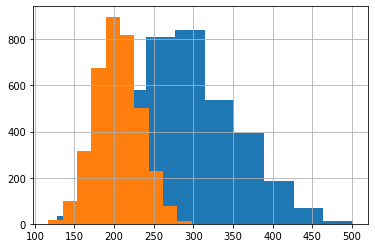

In [ ]:
# Print the new outlier histogram
Outlier_imputation_gc.hist()
Outlier_imputation_vc.hist()

### **Lagging, scaling and normalizing data**

<Figure size 432x288 with 0 Axes>

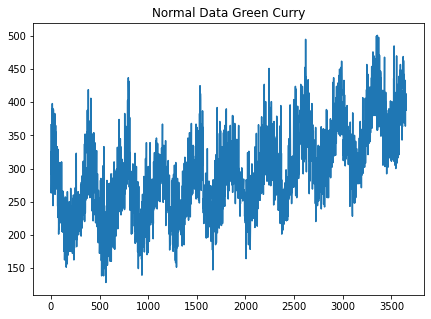

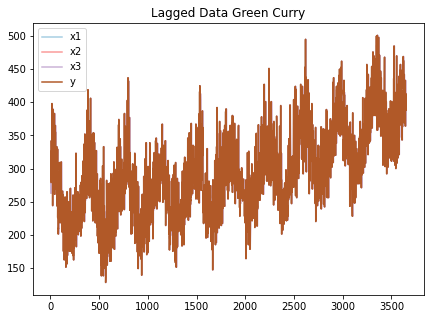

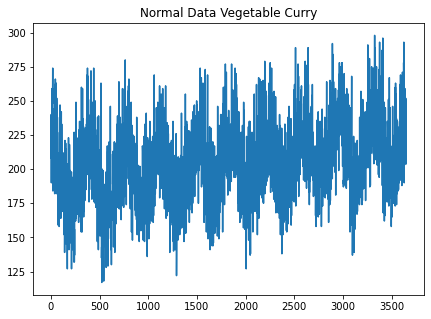

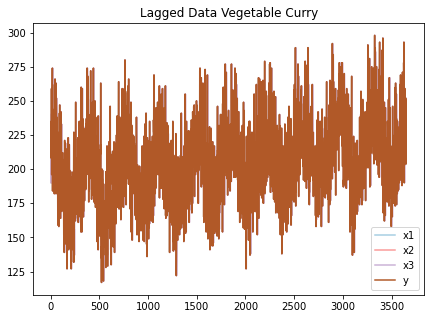

<Figure size 432x288 with 0 Axes>

In [41]:
# Based on out analysis we are to use the information of HampelData
## Green Curry
DB_Hampel_gc = Outlier_imputation_gc.copy(deep=True)
## Vegetable Curry
DB_Hampel_vc = Outlier_imputation_vc.copy(deep=True)
## Combined Curry

#Initialize the index at 1
## Green Curry
DB_Hampel_gc.index = DB_Hampel_gc.index + 1 
## Vegetable Curry
DB_Hampel_vc.index = DB_Hampel_vc.index + 1 

# Lag the DataFrame
## Green Curry
data_gc = pd.concat([DB_Hampel_gc.shift(1), DB_Hampel_gc.shift(2), DB_Hampel_gc.shift(3), DB_Hampel_gc], axis=1)
data_gc.columns = ['x1','x2', 'x3', 'y']
data_gc = data_gc.iloc[4:,]
## Vegetable Curry
data_vc = pd.concat([DB_Hampel_vc.shift(1), DB_Hampel_vc.shift(2), DB_Hampel_vc.shift(3), DB_Hampel_vc], axis=1)
data_vc.columns = ['x1','x2', 'x3', 'y']
data_vc = data_vc.iloc[4:,]
data_vc.head()

# Plot data without Outliers and the lagged Data
## Green Curry
DB_Hampel_gc.plot(figsize=(7,5),title='Normal Data Green Curry')
data_gc.plot(colormap='Paired',figsize=(7,5),title='Lagged Data Green Curry')
plt.figure()
#plt.show()

## Vegetable Curry
DB_Hampel_vc.plot(figsize=(7,5),title='Normal Data Vegetable Curry')
data_vc.plot(colormap='Paired',figsize=(7,5),title='Lagged Data Vegetable Curry')
plt.figure()
#plt.show()

In [ ]:
# Pick 85% of the data but keeps the original sequence (R)
## Green Curry
train_gc = data_gc[:int(data_gc.shape[0]*0.85)]
test_gc = data_gc[int(data_gc.shape[0]*0.85):]
## Vegetable Curry
train_vc = data_vc[:int(data_vc.shape[0]*0.85)]
test_vc = data_vc[int(data_vc.shape[0]*0.85):]

# Clean data in case of missing data
## Green Curry
data_gc = data_gc.dropna()
train_gc = train_gc.dropna()
test_gc = test_gc.dropna()
## Vegetable Curry
data_vc = data_vc.dropna()
train_vc = train_vc.dropna()
test_vc = test_vc.dropna()

# Calculate parameter for scaling back the outcome variable, both for the prediction and the actual values
## Green Curry
ytrain_min_gc = float(train_gc.min()['y'])
ytrain_max_gc = float(train_gc.max()['y'])
ytrain_range_gc = ytrain_max_gc - ytrain_min_gc
ytest_min_gc = float(test_gc.min()['y'])
ytest_max_gc = float(test_gc.max()['y'])
ytest_range_gc = ytest_max_gc - ytest_min_gc
## Vegetable Curry
ytrain_min_vc = float(train_vc.min()['y'])
ytrain_max_vc = float(train_vc.max()['y'])
ytrain_range_vc = ytrain_max_vc - ytrain_min_vc
ytest_min_vc = float(test_vc.min()['y'])
ytest_max_vc = float(test_vc.max()['y'])
ytest_range_vc = ytest_max_vc - ytest_min_vc


# Normalize the train data in the range of 0-1
## Green Curry
train_gc_ = scale(train_gc)
## Vegetable Curry
train_vc_ = scale(train_vc)

# Normalize the test data in the range of 0-1
## Green Curry
test_gc_ = scale(test_gc)
test_gc_
## Vegetable Curry
test_vc_= scale(test_vc)
test_vc_

# Separate the input (x) and output (y)
## Green Curry
n_gc = train_gc_.columns                                # Column labels
xtrain_gc = train_gc_.filter(items = ['x1','x2','x3'])  # Input of the training set
ytrain_gc = train_gc_.filter(items = ['y'])             # Output of the training set
xtest_gc = test_gc_.filter(items = ['x1','x2','x3'])    # Input of the test set
ytest_gc = test_gc_.filter(items = ['y'])               # Output of the test set

## Vegetable Curry
n_vc = train_vc.columns                                # Column labels
xtrain_vc = train_vc.filter(items = ['x1','x2','x3'])  # Input of the training set
ytrain_vc = train_vc.filter(items = ['y'])             # Output of the training set
xtest_vc = test_vc.filter(items = ['x1','x2','x3'])    # Input of the test set
ytest_vc = test_vc.filter(items = ['y'])               # Output of the test set

### **Code refactor for model generation**

In [ ]:
seed = 1

def modelGeneration(models, name, hiddenLayerNeurons, learningRate = 0.0005):
  print(f"Generate a neural network model {name} - Using {hiddenLayerNeurons} Neurons")
  model = Sequential()

  # First add a layer with 3 neurons for 3 input variables (3 lags) and the RELU activation function
  model.add(Dense(3, input_dim=3, activation='relu'))

  # Then add a hidden layer with n neurons and the sigmoid activation function
  model.add(Dense(hiddenLayerNeurons, activation='sigmoid'))

  # Then add the output layer with 1 neuron and a linear activation function
  model.add(Dense(1))
  model.summary()
  print(model.count_params())
  opt = tf.optimizers.Adam(learning_rate=learningRate)
  print("")
  print(f"Generating model {name} ...")
  models[name][hiddenLayerNeurons]['model'] = model
  models[name][hiddenLayerNeurons]['optimizer'] = opt
  return models

def trainModel(models, modelName, modelNeurons, xtrain, ytrain):
  global seed
  models[modelName][modelNeurons]['xtrain_for_parameter_fitting'], models[modelName][modelNeurons]['x_validation'], models[modelName][modelNeurons]['ytrain_for_parameter_fitting'], models[modelName][modelNeurons]['y_validation'] = train_test_split(xtrain, ytrain, test_size=0.3, random_state=seed)
  models[modelName][modelNeurons]['model'].compile(loss='mse', optimizer=models[modelName][modelNeurons]['optimizer'], metrics=['mean_squared_error'])
  models[modelName][modelNeurons]['history'] = models[modelName][modelNeurons]['model'].fit(
      x=models[modelName][modelNeurons]['xtrain_for_parameter_fitting'], 
      y=models[modelName][modelNeurons]['ytrain_for_parameter_fitting'], 
      epochs=200, 
      validation_data=(models[modelName][modelNeurons]['x_validation'],
                       models[modelName][modelNeurons]['y_validation']), 
      verbose=0
      )
  print(f"Model {modelName} generation completed - {modelNeurons} Neurons")
  return models


def plotLearningCurve(models, modelName, modelNeurons):
  models[modelName][modelNeurons]['loss'] = models[modelName][modelNeurons]['history'].history['loss']
  models[modelName][modelNeurons]['val_loss'] = models[modelName][modelNeurons]['history'].history['val_loss']

  print(f"Final loss value in training set for {modelName} with {modelNeurons} neurons: ", models[modelName][modelNeurons]['loss'][-1])
  print(f"Final loss value in validation set for {modelName} with {modelNeurons} neurons: ", models[modelName][modelNeurons]['val_loss'][-1])

  # Plot learning curve
  plt.plot(models[modelName][modelNeurons]['history'].history['loss'], label='Loss (training data)')
  plt.plot(models[modelName][modelNeurons]['history'].history['val_loss'], label='Loss (validation data)')
  plt.title(f'Learning curve - {modelNeurons} Neurons - {modelName}')
  plt.ylabel('Loss')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper right")
  plt.show()

  return models

def predict(models, modelName, modelNeurons):
  # Use the model to calculate predictions for the train set
  y_pred = models[modelName][modelNeurons]['model'].predict(models[modelName]['xtest'])
  models[modelName][modelNeurons]['y_pred_df'] = pd.DataFrame(y_pred)
  models[modelName][modelNeurons]['y_pred_df'].columns =['y'] 

  # Scale back the predictions and original values
  models[modelName][modelNeurons]['y_pred_rescaled'] = scale_back(pd.DataFrame(y_pred), models[modelName]['y_train_min'], models[modelName]['y_train_range'])
  models[modelName][modelNeurons]['y_pred_rescaled'].columns =['y'] 

  models[modelName][modelNeurons]['y_train_rescaled'] = scale_back(pd.DataFrame(models[modelName]['ytest']), models[modelName]['y_test_min'], models[modelName]['y_test_range'])
  models[modelName][modelNeurons]['y_train_rescaled'].head()

  return models

def generateStats(models, modelName, modelNeurons):
  # r-squared
  models[modelName][modelNeurons]['r2_squared'] = r2_score(models[modelName][modelNeurons]['y_train_rescaled'], models[modelName][modelNeurons]['y_pred_rescaled'])
  print(f'R-squared score of the train set for {modelName} with {modelNeurons} neurons: ', round(models[modelName][modelNeurons]['r2_squared'],4))

  # mean squared error
  models[modelName][modelNeurons]['mse'] = mean_squared_error(models[modelName][modelNeurons]['y_train_rescaled'], models[modelName][modelNeurons]['y_pred_rescaled'])
  models[modelName][modelNeurons]['rmse'] = np.sqrt(models[modelName][modelNeurons]['mse'])
  print(f'Root mean squared error of the train set for {modelName} with {modelNeurons} neurons: ', round(models[modelName][modelNeurons]['rmse'], 4))

  # AIC
  # trainable_weights includes neuron weights and biases
  models[modelName][modelNeurons]['param_num'] = models[modelName][modelNeurons]['model'].count_params()
  print(f"Total number of parameters for {modelName} with {modelNeurons} neurons: ", models[modelName][modelNeurons]['param_num'])
  no_data_points = models[modelName][modelNeurons]['xtrain_for_parameter_fitting'].shape[0]
  models[modelName][modelNeurons]['aic'] = no_data_points * np.log(models[modelName][modelNeurons]['mse']) + 2 * models[modelName][modelNeurons]['param_num']
  print(f"Akaike Information Criterion for {modelName} with {modelNeurons} neurons:", round(models[modelName][modelNeurons]['aic'], 4))

  # Corrected AIC
  models[modelName][modelNeurons]['aic_corrected'] = models[modelName][modelNeurons]['aic'] + \
                  2 * models[modelName][modelNeurons]['param_num']*(models[modelName][modelNeurons]['param_num']+1)/(no_data_points - models[modelName][modelNeurons]['param_num'] -1)
  print(f"Corrected Akaike Information Criterion for {modelName} with {modelNeurons} neurons:", round(models[modelName][modelNeurons]['aic_corrected'], 4))

  return models

Generate a neural network model green_curry - Using 3 Neurons
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 12        
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________
28

Generating model green_curry ...
Model green_curry generation completed - 3 Neurons
Final loss value in training set for green_curry with 3 neurons:  0.008340230211615562
Final loss value in validation set for green_curry with 3 neurons:  0.00809818878769874

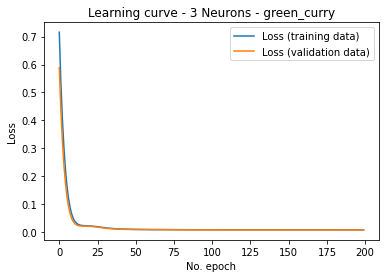

R-squared score of the train set for green_curry with 3 neurons:  -1.856
Root mean squared error of the train set for green_curry with 3 neurons:  82.145
Total number of parameters for green_curry with 3 neurons:  28
Akaike Information Criterion for green_curry with 3 neurons: 19180.012
Corrected Akaike Information Criterion for green_curry with 3 neurons: 19180.7709
Generate a neural network model green_curry - Using 5 Neurons
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 3)                 12        
                                                                 
 dense_4 (Dense)             (None, 5)                 20        
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                                 
Total params: 38
T

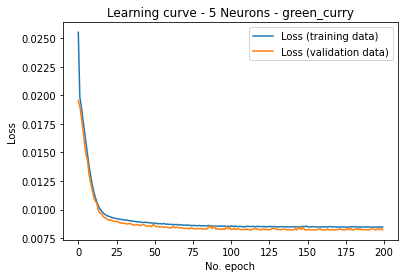

R-squared score of the train set for green_curry with 5 neurons:  -1.7422
Root mean squared error of the train set for green_curry with 5 neurons:  80.4924
Total number of parameters for green_curry with 5 neurons:  38
Akaike Information Criterion for green_curry with 5 neurons: 19111.8522
Corrected Akaike Information Criterion for green_curry with 5 neurons: 19113.2437
Generate a neural network model green_curry - Using 7 Neurons
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 3)                 12        
                                                                 
 dense_7 (Dense)             (None, 7)                 28        
                                                                 
 dense_8 (Dense)             (None, 1)                 8         
                                                                 
Total params: 4

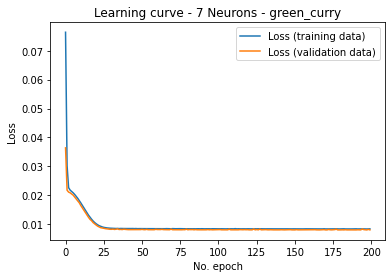

R-squared score of the train set for green_curry with 7 neurons:  -1.7594
Root mean squared error of the train set for green_curry with 7 neurons:  80.7443
Total number of parameters for green_curry with 7 neurons:  48
Akaike Information Criterion for green_curry with 7 neurons: 19145.4072
Corrected Akaike Information Criterion for green_curry with 7 neurons: 19147.6261
Generate a neural network model green_curry - Using 9 Neurons
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 3)                 12        
                                                                 
 dense_10 (Dense)            (None, 9)                 36        
                                                                 
 dense_11 (Dense)            (None, 1)                 10        
                                                                 
Total params: 5

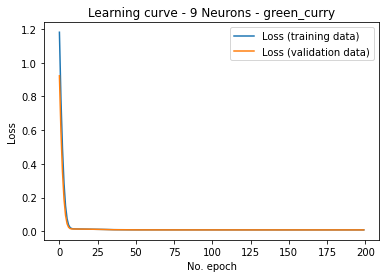

R-squared score of the train set for green_curry with 9 neurons:  -1.6326
Root mean squared error of the train set for green_curry with 9 neurons:  78.8671
Total number of parameters for green_curry with 9 neurons:  58
Akaike Information Criterion for green_curry with 9 neurons: 19063.3632
Corrected Akaike Information Criterion for green_curry with 9 neurons: 19066.6068
Generate a neural network model vegetable_curry - Using 3 Neurons
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 3)                 12        
                                                                 
 dense_13 (Dense)            (None, 3)                 12        
                                                                 
 dense_14 (Dense)            (None, 1)                 4         
                                                                 
Total param

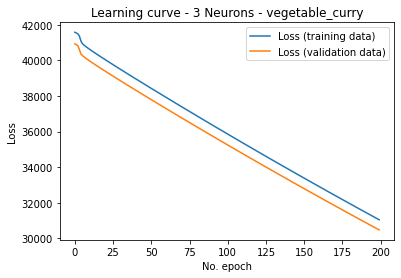

R-squared score of the train set for vegetable_curry with 3 neurons:  -48.1696
Root mean squared error of the train set for vegetable_curry with 3 neurons:  29821.6778
Total number of parameters for vegetable_curry with 3 neurons:  28
Akaike Information Criterion for vegetable_curry with 3 neurons: 44750.3743
Corrected Akaike Information Criterion for vegetable_curry with 3 neurons: 44751.1332
Generate a neural network model vegetable_curry - Using 5 Neurons
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 3)                 12        
                                                                 
 dense_16 (Dense)            (None, 5)                 20        
                                                                 
 dense_17 (Dense)            (None, 1)                 6         
                                                     

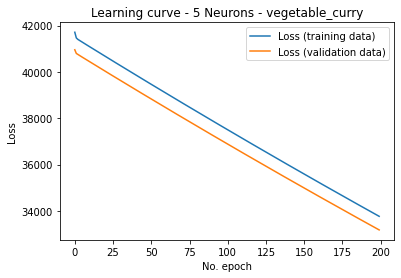

R-squared score of the train set for vegetable_curry with 5 neurons:  -52.6408
Root mean squared error of the train set for vegetable_curry with 5 neurons:  31148.0847
Total number of parameters for vegetable_curry with 5 neurons:  38
Akaike Information Criterion for vegetable_curry with 5 neurons: 44959.1519
Corrected Akaike Information Criterion for vegetable_curry with 5 neurons: 44960.5434
Generate a neural network model vegetable_curry - Using 7 Neurons
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 3)                 12        
                                                                 
 dense_19 (Dense)            (None, 7)                 28        
                                                                 
 dense_20 (Dense)            (None, 1)                 8         
                                                     

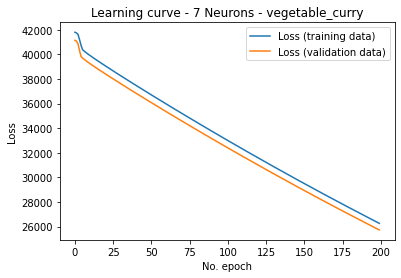

R-squared score of the train set for vegetable_curry with 7 neurons:  -40.3207
Root mean squared error of the train set for vegetable_curry with 7 neurons:  27338.0589
Total number of parameters for vegetable_curry with 7 neurons:  48
Akaike Information Criterion for vegetable_curry with 7 neurons: 44413.1603
Corrected Akaike Information Criterion for vegetable_curry with 7 neurons: 44415.3792
Generate a neural network model vegetable_curry - Using 9 Neurons
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 3)                 12        
                                                                 
 dense_22 (Dense)            (None, 9)                 36        
                                                                 
 dense_23 (Dense)            (None, 1)                 10        
                                                     

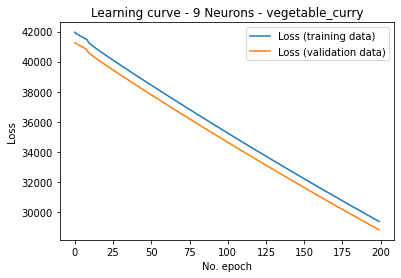

R-squared score of the train set for vegetable_curry with 9 neurons:  -45.3912
Root mean squared error of the train set for vegetable_curry with 9 neurons:  28966.8487
Total number of parameters for vegetable_curry with 9 neurons:  58
Akaike Information Criterion for vegetable_curry with 9 neurons: 44684.2099
Corrected Akaike Information Criterion for vegetable_curry with 9 neurons: 44687.4535


In [ ]:
modelNeurons = [3, 5, 7, 9]

models = {
    'green_curry': {
        'data': data_gc,
        'xtest': xtest_gc,
        'ytest': ytest_gc,
        'xtrain': xtrain_gc,
        'ytrain': ytrain_gc,
        'y_train_min': ytrain_min_gc,
        'y_train_max': ytrain_max_gc,
        'y_train_range': ytrain_range_gc,
        'y_test_min': ytest_min_gc,
        'y_test_max': ytest_max_gc,
        'y_test_range': ytest_range_gc,
    },
    'vegetable_curry': {
        'data': data_vc,
        'xtest': xtest_vc,
        'ytest': ytest_vc,
        'xtrain': xtrain_vc,
        'ytrain': ytrain_vc,
        'y_train_min': ytrain_min_vc,
        'y_train_max': ytrain_max_vc,
        'y_train_range': ytrain_range_vc,
        'y_test_min': ytest_min_vc,
        'y_test_max': ytest_max_vc,
        'y_test_range': ytest_range_vc,
    }
}

for name in models:
  for neurons in modelNeurons:
    models[name][neurons] = {}
    models = modelGeneration(models, name, neurons)
    models = trainModel(models, name, neurons, models[name]['xtrain'], models[name]['ytrain'])
    plotLearningCurve(models, name, neurons)
    models = predict(models, name, neurons)
    models = generateStats(models, name, neurons)

In [ ]:
# Ejemplo de como obtener la información de los modelos
# MODELS [ nombre ] [ neuronas ] [ variable ]
print("Model for Green Curry with " + str(models['green_curry'][3]['aic_corrected']))
print("\n")
print("Model for Vegetable Curry with " + str(models['vegetable_curry'][3]['aic_corrected']))

Model for Green Curry with 19180.77087297715


Model for Vegetable Curry with 44751.13319266275


In [ ]:
models.generateStats()

AttributeError: ignored

In [ ]:
# Ejemplo de como obtener la información de los modelos
# MODELS [ nombre ] [ neuronas ] [ variable ]
aic_corrected_information_gc = []
aic_corrected_information_vc = []
neurons_required = [3,5,7,9]
for neurons in neurons_required:
  aic_corrected_information_gc.append(models['green_curry'][neurons]['aic_corrected'])
  aic_corrected_information_vc.append(models['vegetable_curry'][neurons]['aic_corrected'])

KeyError: ignored

In [ ]:
print(models['green_curry'][3]['aic_corrected'])

In [ ]:
import numpy as np
Corrected_Akaike_Information = pd.DataFrame(np.column_stack([aic_corrected_information_gc,aic_corrected_information_vc]), 
                               columns=['Green Curry', 'Vegetable Curry'])

## **STEP 2 - Approach 1**
Use the results of the product-level models in Step 1 to calculate a forecast for the curry category. In other words, the forecast of the curry category is equal to forecast with FA + forecast with FB.

In [ ]:
# Read the CSV file, store it as a DataFrame and make sure it has no NaN values
df_vc_approach1 = pd.read_csv("green-thai-curry-sales.csv") # reading csv
df_gc_approach1 = pd.read_csv("vegetable-korma-curry-sales.csv") # reading csv

# Concatenate both DataFrames of STEP1
df_step1 = pd.concat([df_gc_output,df_vc_output]).groupby(['Date']).Sales.sum().reset_index()

# Concatenate both DataFrames for the following steps
df_approach1 = pd.concat([df_vc_approach1,df_gc_approach1]).groupby(['Date']).Sales.sum().reset_index()
df_approach1 

,Date,Sales
0,1/1/2011,574
1,1/1/2012,509
2,1/1/2013,520
3,1/1/2014,518
4,1/1/2015,561
...,...,...
3645,9/9/2016,467
3646,9/9/2017,487
3647,9/9/2018,552
3648,9/9/2019,539


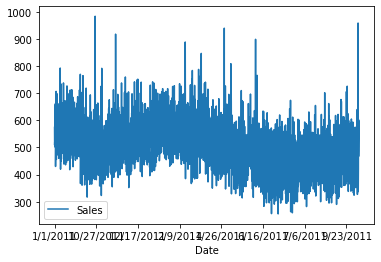

In [ ]:
# Display the data combined
df_approach1.plot(x='Date',y='Sales')
plt.show()

Outlier Indices:  [68, 107, 127, 148, 149, 153, 159, 188, 189, 197, 198, 319, 422, 487, 499, 501, 509, 732, 783, 818, 838, 839, 845, 858, 987, 998, 1030, 1049, 1077, 1078, 1099, 1119, 1130, 1148, 1176, 1235, 1236, 1295, 1296, 1356, 1363, 1366, 1499, 1563, 1567, 1570, 1679, 1707, 1727, 1749, 1798, 1799, 1839, 1885, 1919, 1964, 1969, 2035, 2104, 2114, 2229, 2259, 2334, 2342, 2349, 2410, 2429, 2559, 2601, 2681, 2687, 2688, 2759, 2789, 2855, 2930, 2987, 2989, 2997, 2999, 3049, 3069, 3109, 3119, 3128, 3159, 3164, 3180, 3181, 3239, 3270, 3281, 3287, 3321, 3412, 3499, 3639]


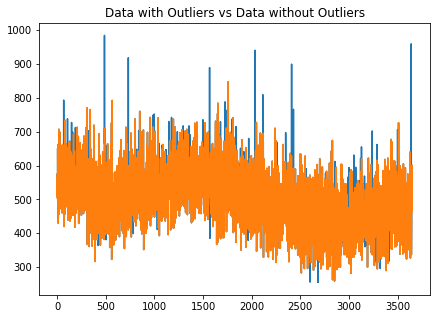

<Figure size 432x288 with 0 Axes>

In [ ]:
# Outlier detection for combined DataFrame
outlier_approach1 = hampel(df_approach1.Sales, window_size=5, n=3)
print("Outlier Indices: ", outlier_approach1)

# Outlier Imputation with rolling median for green curry
Outlier_imputation_approach1 = hampel(df_approach1.Sales, window_size=5, n=3, imputation=True) # If set to False, then the algorithm will be used for outlier detection. If set to True, then the algorithm will also imput the outliers with the rolling median.

# Plot Original Data vs. Outliers for green curry
df_approach1.Sales.plot(figsize=(7,5),title='Data with Outliers vs Data without Outliers')
Outlier_imputation_approach1.plot()
plt.figure()
plt.show()

In [ ]:
# Rename data to be handled
df_combined = Outlier_imputation_approach1.copy(deep=True)
df_combined.head()

0    574.0
1    509.0
2    520.0
3    518.0
4    561.0
Name: Sales, dtype: float64

In [ ]:
# Use 'r2_score' to analyze the forecast
r2_approach1 = r2_score(df_step1.Sales,df_approach1.Sales)
print('The R-squared score for the TrainSet:', round(r2_approach1,4))
# Use 'mean square error' to analyze the forecast
meanSE_approach1= mean_squared_error(df_step1.Sales, df_approach1.Sales)
meanSE_approach1= np.sqrt(meanSE_approach1)
print('Root mean squared error of the train set:', round(meanSE_approach1,4))

The R-squared score for the TrainSet: 0.5772
Root mean squared error of the train set: 57.404


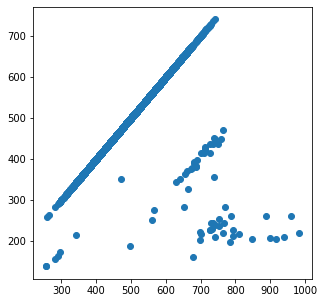

In [ ]:
# Display Original Data vs Predicted Data
plt.figure(figsize=(5,5))
plt.scatter(x = df_approach1.Sales, y = df_step1.Sales)

## **STEP 3 - Approach 2**
Develop an aggregate neural network model for the curry category, using the total demand given by DA + DB as input data. Use 85% of the data for training and the rest for testing. Use a single hidden layer. Vary the number of neurons in the hidden layer using 3, 5, 7, and 9 neurons, to train four ANN models (for each architecture, record the Akaike Information Criteria).
* 3.1 Make a table that shows the Akaike Information Criteria for each number of neurons for the
aggregate model.
* 3.2 Report the best number of neurons in the hidden layer for the aggregate model

#### **Import and Arrange Data**

In [23]:
from google.colab import drive
drive.mount('/content/drive')

# Read the CSV file, store it as a DataFrame and make sure it has no NaN values
# Vegetable Curry
url_vc='https://drive.google.com/file/d/1Yd4OcWul48u2RLakt3CfmFAs7hrSSVCE/view?usp=sharing'
path_vc ='https://drive.google.com/uc?id=' + url_vc.split('/')[-2]
df_vc_approach2 = pd.read_csv(path_vc)

# Green Curry
url_gc='https://drive.google.com/file/d/1YXz_BBT83XPFmQgCoIAuY4MCCsz3ohhj/view?usp=sharing'
path_gc ='https://drive.google.com/uc?id=' + url_gc.split('/')[-2]
df_gc_approach2 = pd.read_csv(path_gc)

# Concatenate both DataFrames for the following steps
df_combined_ap2 = pd.concat([df_gc_approach2,df_vc_approach2]).groupby(['Date']).Sales.sum().reset_index()

# Make sure that there are no NaN values present
print(f"TotalCurry")
print(df_combined_ap2.info())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TotalCurry
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3650 non-null   object
 1   Sales   3650 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.2+ KB
None


##### **Outliers - Hempel Filter**

* https://medium.com/wwblog/clean-up-your-time-series-data-with-a-hampel-filter-58b0bb3ebb04
* https://pypi.org/project/hampel/

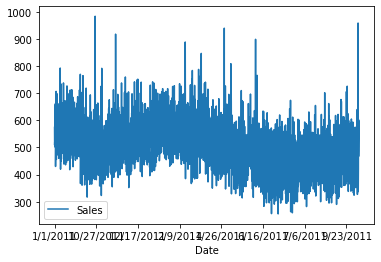

In [24]:
# Display the data combined
df_combined_ap2.plot(x='Date',y='Sales')
plt.show()

Outlier Indices:  [153, 197, 487, 839, 998, 1295, 1296, 1499, 1567, 1727, 1749, 1798, 1799, 1885, 2035, 2114, 2334, 2349, 2429, 2681, 2999, 3049, 3287, 3639]


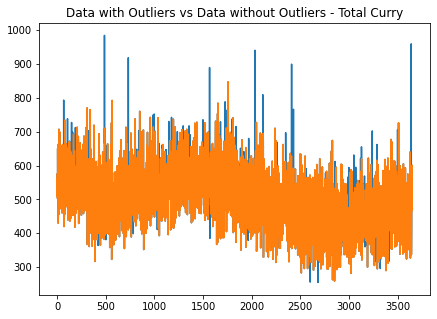

<Figure size 432x288 with 0 Axes>

In [55]:
# Outlier detection for combined DataFrame
outlier_indices_combined_ap2 = hampel(df_combined_ap2.Sales, window_size=5, n=5)
print("Outlier Indices: ", outlier_indices_combined_ap2)

# Outlier Imputation with rolling median for green curry
Outlier_imputation_combined_ap2 = hampel(df_combined_ap2.Sales, window_size=5, n=3, imputation=True) # If set to False, then the algorithm will be used for outlier detection. If set to True, then the algorithm will also imput the outliers with the rolling median.

# Plot Original Data vs. Outliers for green curry
df_combined_ap2.Sales.plot(figsize=(7,5),title='Data with Outliers vs Data without Outliers - Total Curry')
Outlier_imputation_combined_ap2.plot()
plt.figure()
plt.show()

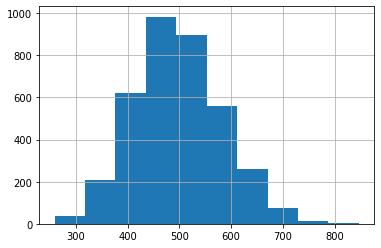

In [56]:
# Print the new outlier histogram
Outlier_imputation_combined_ap2.hist()

### **Lagging, scaling and normalizing data**

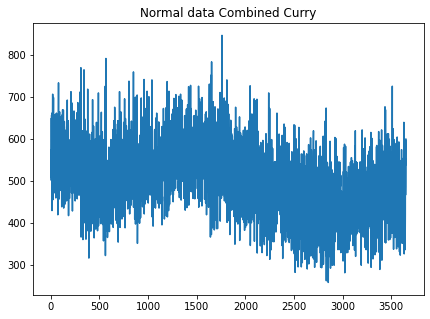

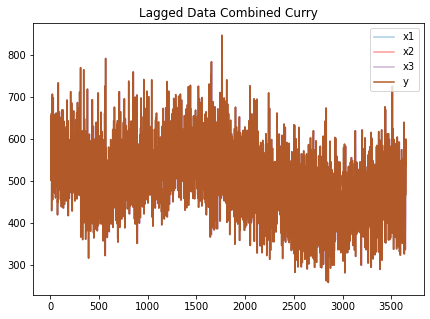

In [57]:
# Based on out analysis we are to use the information of HampelData
DF_Hampel_combined = Outlier_imputation_combined_ap2.copy(deep=True)

#Initialize the index at 1
DF_Hampel_combined.index = DF_Hampel_combined.index + 1 

# Lag the DataFrame
data_combined = pd.concat([DF_Hampel_combined.shift(1), DF_Hampel_combined.shift(2), DF_Hampel_combined.shift(3), DF_Hampel_combined], axis=1)
data_combined.columns = ['x1','x2', 'x3', 'y']
data_combined = data_combined.iloc[4:,]
data_combined.head()

# Plot data without Outliers and the lagged Data
plt.figure()
DF_Hampel_combined.plot(figsize=(7,5),title='Normal data Combined Curry')
data_combined.plot(colormap='Paired',figsize=(7,5),title='Lagged Data Combined Curry')
plt.show()

In [52]:
# Pick 85% of the data but keeps the original sequence (R)
train_combined = data_combined[:int(df_combined.shape[0]*0.85)]
test_combined = data_combined[int(df_combined.shape[0]*0.85):]

# Clean data in case of missing data
df_combined = data_combined.dropna()
train_combined = train_combined.dropna()
test_combined = test_combined.dropna()


# Calculate parameter for scaling back the outcome variable, both for the prediction and the actual values
ytrain_min_combined = float(train_combined.min()['y'])
ytrain_max_combined = float(train_combined.max()['y'])
ytrain_range_combined = ytrain_max_combined - ytrain_min_combined

ytest_min_combined = float(test_combined.min()['y'])
ytest_max_combined = float(test_combined.max()['y'])
ytest_range_combined = ytest_max_combined - ytest_min_combined


# Normalize the train data in the range of 0-1
train_ = scale(train_combined)

# Normalize the test data in the range of 0-1
test_ = scale(test_combined)
test_

# Separate the input (x) and output (y)
n_combined= train_.columns                                # Column labels
xtrain_combined = train_.filter(items = ['x1','x2','x3'])  # Input of the training set
ytrain_combined = train_.filter(items = ['y'])             # Output of the training set

xtest_combined = test_.filter(items = ['x1','x2','x3'])    # Input of the test set
ytest_combined = test_.filter(items = ['y'])               # Output of the test set

ytest_combined.head()

,y
3107,0.220183
3108,0.500000
3109,0.366972
3110,0.309633
3111,0.247706


## **STEP 4**
Use scatter plots to compare predicted against actual values for approaches 1 and 2.

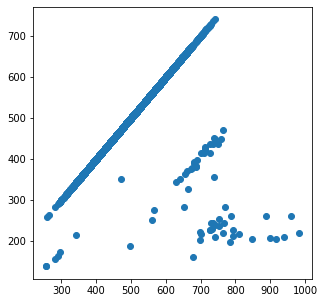

In [ ]:
# Display Original Data vs Predicted Data
plt.figure(figsize=(5,5))
plt.scatter(x = df_approach1.Sales, y = df_step1.Sales)

## **STEP 5**
Report the precision of approaches 1 and 2 in terms of Root Mean Squared Error and determination coefficient r 2.

## **STEP 6**

Write a paper in which you briefly explain: data understanding, data preparation, modeling, and evaluation steps according to the *CRISP* methodology. Include a table listing the activities carried out by each team member. Limit the length of the paper to a maximum of four pages. Include an Excel or Python
file with the calculations of Step 5. Also, include the Jupyter Notebooks that you used to generate the
models.

# **GREEN THAI CURRY SALES**

# **NOTE**

Remember that the data preparation requires the identification, removal, and replacement of outliers. If such a preparation is needed document the approach that you followed. The following references provide information for the detection and processing of outliers:
* Hampel filter
> https://medium.com/wwblog/clean-up-your-time-series-data-with-a-hampel-filter-58b0bb3ebb04
* Outlier identification and replacement
> https://www.pluralsight.com/guides/cleaning-up-data-from-outliers
* Outlier detection in Python
> https://towardsdatascience.com/practical-implementation-of-outlier-detection-in-python-90680453b3ce